In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score


%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

In [2]:
def load_features(files):
    df = pd.read_csv('../dataset/train.csv', index_col=0, usecols=['id', 'target'])
    for file in files:
        df = df.merge(pd.read_csv(file, index_col=0), how='outer', left_index=True, right_index=True)
    return df

In [3]:
full_model = load_features(['../features/features_basicas_texto.csv'])
# TODO: we need only numeric features, maybe this conversion should be done in the feature notebook
# This encoding is WRONG, we should use one hot encoding or mean encoding
conversion = {'pos': 1, 'neg': -1, 'neu': 0}
full_model['sentiment'] = full_model['sentiment'].apply(lambda x: conversion[x])

model = full_model[full_model['target'].notnull()]
labels = model['target']
model = model.drop('target', axis=1)

model

,word_count,unique_words_count,word_count_above_mean,unique_words_count_above_mean,char_count,char_count_above_mean,avg_word_length,sentiment,subjectivity,polarity
id,,,,,,,,,,
1,7,7,0,0,38,0,5.428571,1,0.000000,0.2732
4,7,7,0,0,31,0,4.428571,-1,0.400000,-0.3400
5,11,9,1,0,78,1,7.090909,0,0.400000,0.0000
6,8,8,0,0,53,1,6.625000,0,0.000000,0.0000
7,10,10,1,1,47,0,4.700000,0,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...
10869,9,9,0,0,46,0,5.111111,-1,1.000000,-0.4939
10870,9,9,0,0,56,1,6.222222,-1,0.400000,-0.5423
10871,6,6,0,0,27,0,4.500000,0,0.000000,0.0000


# Feature Importance

In [4]:
def feature_importance(model, classifier):
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    indexes = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(model.shape[1]):
        print(f"{f + 1}. feature {indexes[f]}: {model.columns[f]} ({importances[indexes[f]]})")
    print()
    plt.figure(figsize=(24,12))
    plt.title("Features por importancia")
    plt.bar(range(model.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
    plt.xticks(range(model.shape[1]), indexes)
    plt.xlim([-1, model.shape[1]])
    plt.show()

## Con Random Forest

In [5]:
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0,
                              class_weight ={1:1})
forest.fit(model, labels.values.ravel())

ExtraTreesClassifier(class_weight={1: 1}, n_estimators=500, random_state=0)

Feature ranking:
1. feature 9: word_count (0.23485436487649197)
2. feature 4: unique_words_count (0.1896384158962479)
3. feature 6: word_count_above_mean (0.17829849316454155)
4. feature 8: unique_words_count_above_mean (0.1630163754303324)
5. feature 1: char_count (0.08785343549117153)
6. feature 0: char_count_above_mean (0.07760310415976253)
7. feature 7: avg_word_length (0.03687079274592908)
8. feature 5: sentiment (0.016238521510746288)
9. feature 2: subjectivity (0.0082033832211118)
10. feature 3: polarity (0.007423113503664881)



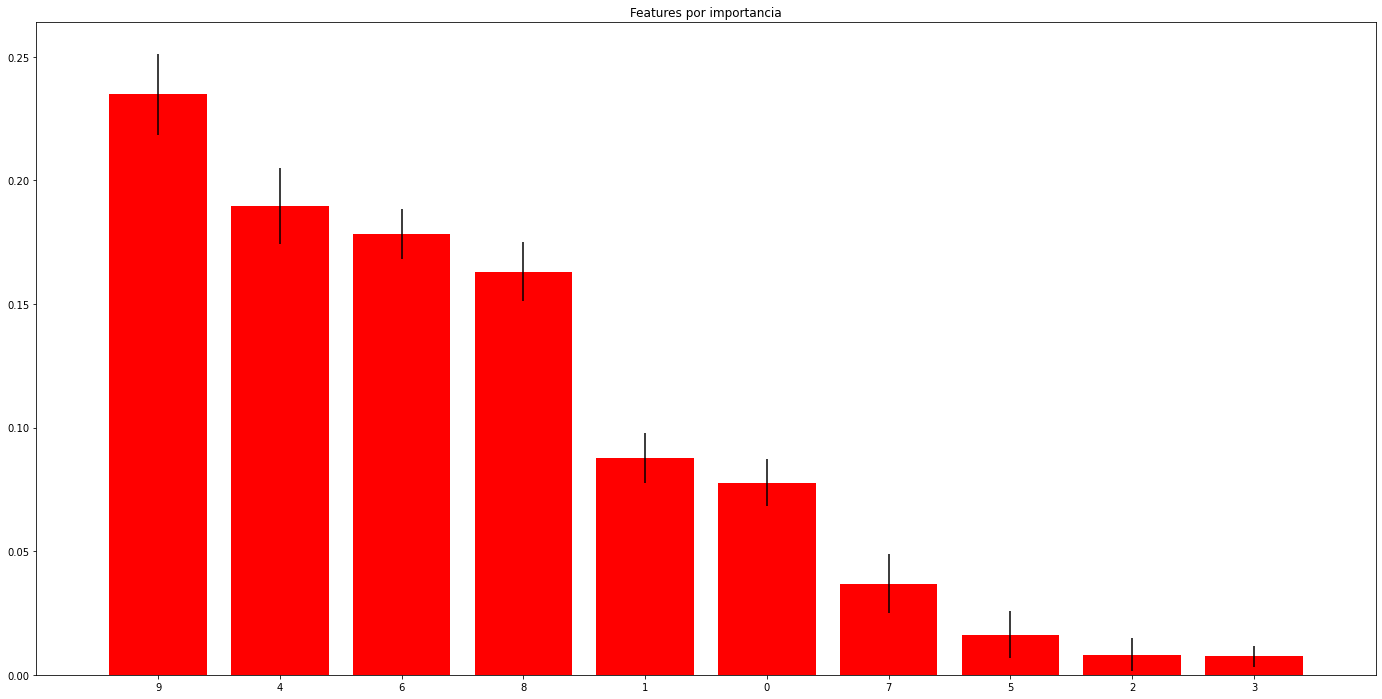

In [6]:
feature_importance(model, forest)

# Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(model, labels,test_size=0.2)
len(X_train),len(X_test),len(y_train),len(y_test)

(6090, 1523, 6090, 1523)

# Probando clasificadores

In [8]:
def try_classifier(classifier):
    classifier.fit(X_train, y_train.values.ravel())
    predictions = classifier.predict(X_test)
    predictions_with_prob = classifier.predict_proba(X_test)[:,1]
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f'Verdaderos Negativos: {tn}')
    print(f'Falsos Negativos: {fn}')
    print(f'Verdaderos Positivos: {tp}')
    print(f'Falsos Positivos: {fp}')
    print()
    print(f'accuracy score: {accuracy_score(y_test, predictions)}')
    print(f'roc auc score: {roc_auc_score(y_test,  predictions_with_prob)}')
    print(f'f1 score: {f1_score(y_test,  predictions)}')
    print()
    fig, axs = plt.subplots(3)
    fig.set_size_inches(25,10)
    plt.subplots_adjust(hspace=0.4)
    xgb.plot_importance(xgb_classifier, ax=axs[0], importance_type='weight', title='Feature Importance (weight)')
    xgb.plot_importance(xgb_classifier, ax=axs[1], importance_type='gain', title='Feature Importance (gain)')
    xgb.plot_importance(xgb_classifier, ax=axs[2], importance_type='cover', title='Feature Importance (cover)')
    plt.show()
    return classifier

## XGBoost

In [9]:
# grid search para encontrar hiperparametros

#xgb_classifier = GridSearchCV(
#    xgb.XGBClassifier(),
#    {
#        'max_depth': [1,2,3,4,5,6,7,8,9,10],
#        'n_estimators' :[100,200,500,1000],
#        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
#        'scale_pos_weight': [0.8, 1, 1.2]
#    },
#    scoring="f1",
#    n_jobs=-1,
#    refit=True
#)
#xgb_classifier.best_params_

Verdaderos Negativos: 537
Falsos Negativos: 230
Verdaderos Positivos: 444
Falsos Positivos: 312

accuracy score: 0.6441234405778069
roc auc score: 0.7045572903013844
f1 score: 0.620979020979021



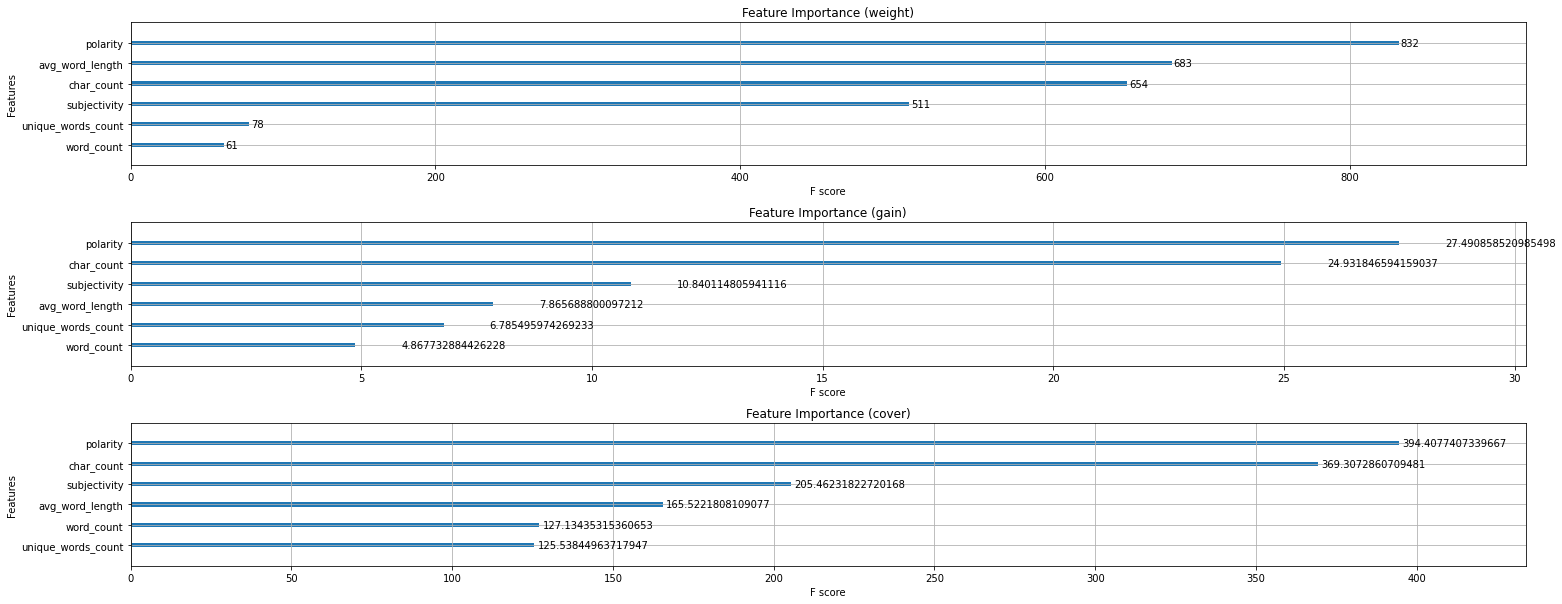

In [10]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=5,
    learning_rate=0.01,
    n_estimators=100,
    scale_pos_weight=1.2
)

xgb_classifier = try_classifier(xgb_classifier)


## LightGBM

Verdaderos Negativos: 600
Falsos Negativos: 276
Verdaderos Positivos: 398
Falsos Positivos: 249

accuracy score: 0.6552856204858831
roc auc score: 0.7026873997336716
f1 score: 0.6025738077214231



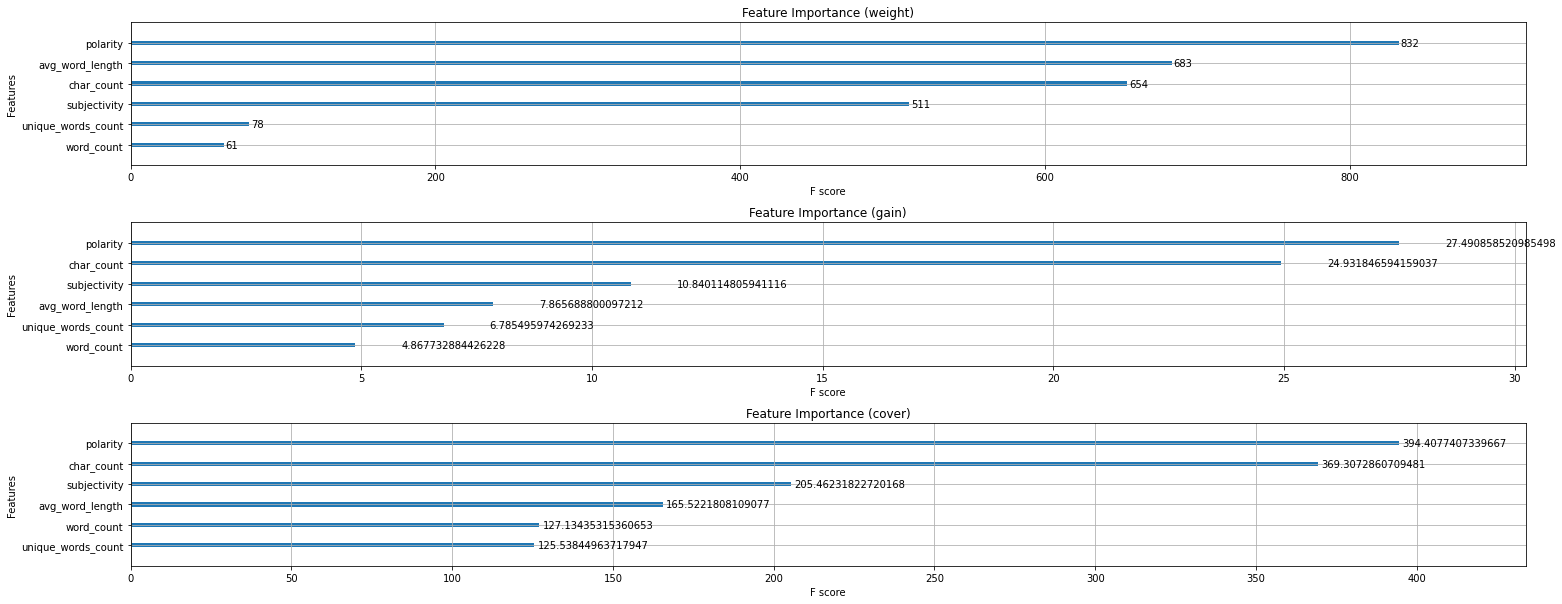

In [11]:
lgbm_classifier = lgb.LGBMClassifier(   
    objective='binary',
    boosting='goss',
    scale_pos_weight=1.2,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5, 
    num_threads=8,        
)

lgbm_classifier = try_classifier(lgbm_classifier)

## Random Forest

Verdaderos Negativos: 523
Falsos Negativos: 232
Verdaderos Positivos: 442
Falsos Positivos: 326

accuracy score: 0.6336178594878529
roc auc score: 0.6990699478877227
f1 score: 0.6130374479889042



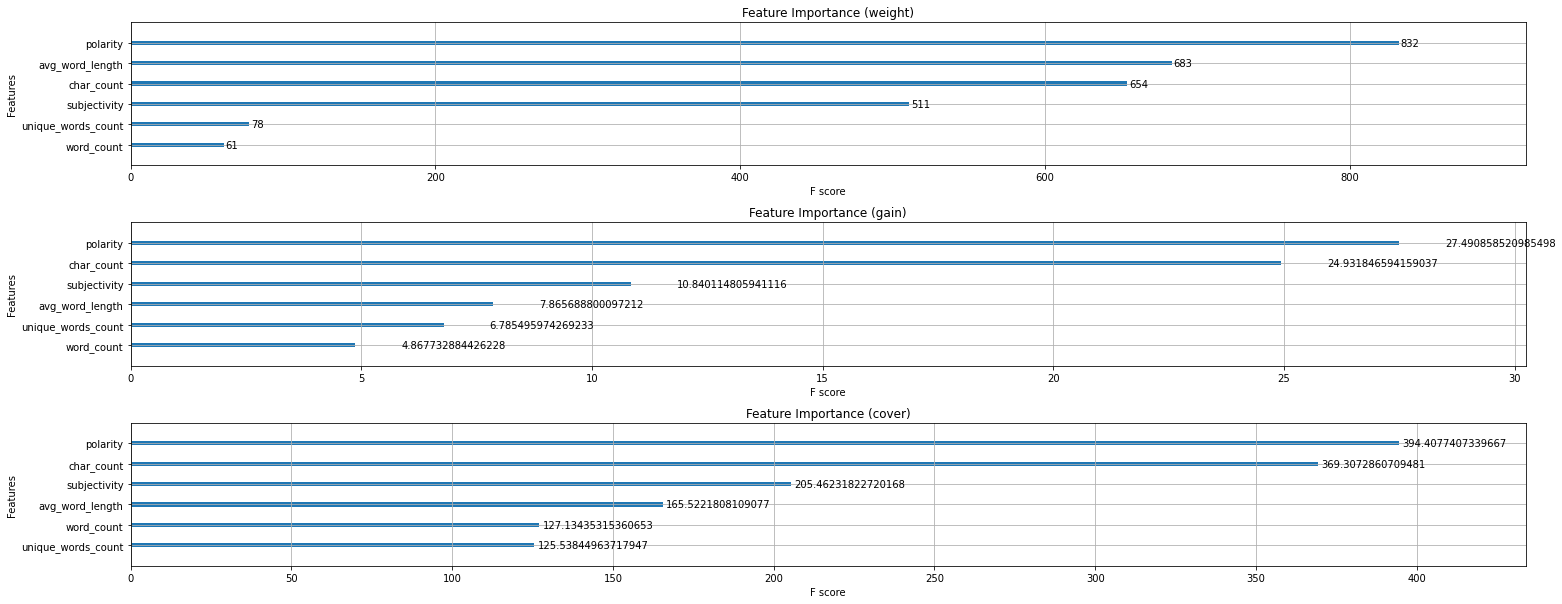

In [12]:
rf_classifier = RandomForestClassifier(
    criterion= 'entropy',
    max_depth= 5,
    n_estimators=100,
    max_features= 'auto',
    class_weight={1:1.2},
    n_jobs=-1
)
rf_classifier = try_classifier(rf_classifier)

## Catboost

Verdaderos Negativos: 532
Falsos Negativos: 237
Verdaderos Positivos: 437
Falsos Positivos: 317

accuracy score: 0.6362442547603414
roc auc score: 0.6885671046055231
f1 score: 0.6120448179271709



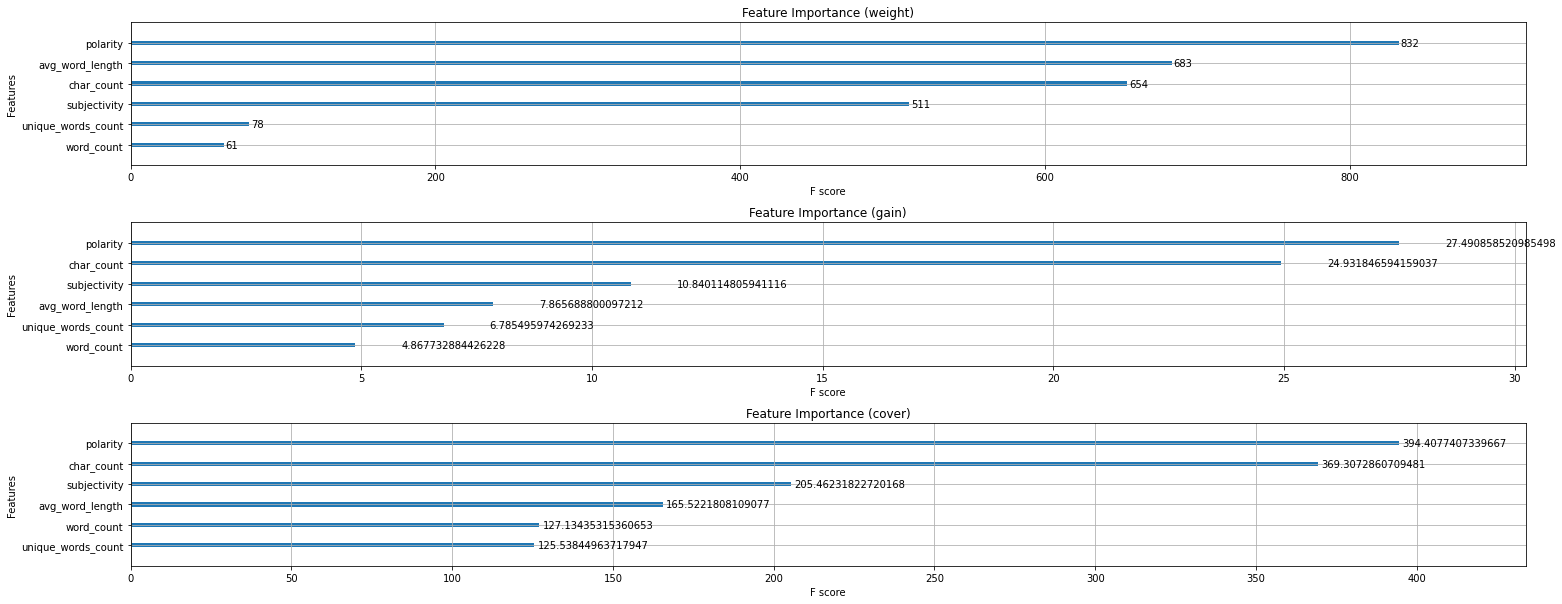

In [13]:
catboost_classifier = CatBoostClassifier(
    class_weights=[1, 1.2],
    logging_level='Silent',
    thread_count=8,
    depth=5,
    n_estimators=100,
    learning_rate=0.01
)

catboost_classifier = try_classifier(catboost_classifier)

# Prepare predictions

In [14]:
test = full_model[full_model['target'].isnull()]
test = test.drop('target', axis=1)

In [15]:
predictions = xgb_classifier.predict(test)

In [16]:
result = pd.DataFrame(data={'id': test.index, 'target': predictions})

In [17]:
now = datetime.now(tz=None).strftime('%Y-%m-%dT%H:%M:%S')
result.to_csv(f'../predictions/prediction_{now}.csv', encoding='utf-8', index=False)